# Movie Review Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [2]:
"""
Build a sentiment analysis / polarity model

Sentiment analysis can be casted as a binary text classification problem,
that is fitting a linear classifier on features extracted from the text
of the user messages so as to guess whether the opinion of the author is
positive or negative.

In this examples we will use a movie review dataset.
"""
# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: Simplified BSD

import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics

To begin with, the dataset that we used to implement our machine learning algorithm is called **Movie Review Data**, downloaded from https://www.cs.cornell.edu/people/pabo/movie-review-data/. This webpage is a distribution site for movie-review data for use in sentiment-analysis experiments. 

In this __Movie Review Dataset__, we have 2000 collections of movie-review documents labeled with respect to their overall sentiment polarity (1000 positive reviews and 1000 negative reviews).

In [3]:
movie_reviews_data_folder = "txt_sentoken"
print("before loading")
dataset = load_files(movie_reviews_data_folder, shuffle=False)
print("n_samples: %d" % len(dataset.data))

print(f"Number of Positive Review --> {np.count_nonzero(dataset.target)}")
print(f"Number of Negative Review --> {len(dataset.data) - np.count_nonzero(dataset.target)}")

before loading
n_samples: 2000
Number of Positive Review --> 1000
Number of Negative Review --> 1000


In [4]:
df = pd.DataFrame({"text": [text.decode() for text in dataset.data],
                   "target": dataset.target})
display(df.head(10))
display(df.tail(10))

,text,target
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard's quick movie review \ndamn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' firs...",0
4,synopsis : a mentally unstable man undergoing ...,0
5,capsule : in 2176 on the planet mars police ta...,0
6,"so ask yourself what "" 8mm "" ( "" eight millime...",0
7,that's exactly how long the movie felt to me ....,0
8,call it a road trip for the walking wounded . ...,0
9,plot : a young french boy sees his parents kil...,0


,text,target
1990,the relaxed dude rides a roller coaster \nthe ...,1
1991,i don't box with kid gloves . \ni don't play n...,1
1992,"here is a film that is so unexpected , so scar...",1
1993,plot : this movie takes place over one day . \...,1
1994,"a thriller set in modern day seattle , that ma...",1
1995,wow ! what a movie . \nit's everything a movie...,1
1996,"richard gere can be a commanding actor , but h...",1
1997,"glory--starring matthew broderick , denzel was...",1
1998,steven spielberg's second epic film on world w...,1
1999,"truman ( "" true-man "" ) burbank is the perfect...",1


## Data cleaning
### Step 1: Remove punctuation in our dataset

In [5]:
import string

df["text_wo_punct"] = df["text"].apply(
    lambda text: "".join(ch for ch in text if ch not in string.punctuation))
df.head()

,text,target,text_wo_punct
0,"plot : two teen couples go to a church party ,...",0,plot two teen couples go to a church party d...
1,the happy bastard's quick movie review \ndamn ...,0,the happy bastards quick movie review \ndamn t...
2,it is movies like these that make a jaded movi...,0,it is movies like these that make a jaded movi...
3,""" quest for camelot "" is warner bros . ' firs...",0,quest for camelot is warner bros first fe...
4,synopsis : a mentally unstable man undergoing ...,0,synopsis a mentally unstable man undergoing p...


### Step 2: Tokenization - spliting strings into a list of words

In [6]:
df["text_wo_punct_split"] = df["text_wo_punct"].apply(
    lambda text: re.split("\W+", text.lower()))
df.head()

,text,target,text_wo_punct,text_wo_punct_split
0,"plot : two teen couples go to a church party ,...",0,plot two teen couples go to a church party d...,"[plot, two, teen, couples, go, to, a, church, ..."
1,the happy bastard's quick movie review \ndamn ...,0,the happy bastards quick movie review \ndamn t...,"[the, happy, bastards, quick, movie, review, d..."
2,it is movies like these that make a jaded movi...,0,it is movies like these that make a jaded movi...,"[it, is, movies, like, these, that, make, a, j..."
3,""" quest for camelot "" is warner bros . ' firs...",0,quest for camelot is warner bros first fe...,"[, quest, for, camelot, is, warner, bros, firs..."
4,synopsis : a mentally unstable man undergoing ...,0,synopsis a mentally unstable man undergoing p...,"[synopsis, a, mentally, unstable, man, undergo..."


### Step 3: Remove stop words

In [7]:
stopword = stopwords.words("english")

df['text_wo_punct_split_wo_stopwords'] = df['text_wo_punct_split'].apply(
    lambda words: [word for word in words if word not in stopword])
df.head()

,text,target,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords
0,"plot : two teen couples go to a church party ,...",0,plot two teen couples go to a church party d...,"[plot, two, teen, couples, go, to, a, church, ...","[plot, two, teen, couples, go, church, party, ..."
1,the happy bastard's quick movie review \ndamn ...,0,the happy bastards quick movie review \ndamn t...,"[the, happy, bastards, quick, movie, review, d...","[happy, bastards, quick, movie, review, damn, ..."
2,it is movies like these that make a jaded movi...,0,it is movies like these that make a jaded movi...,"[it, is, movies, like, these, that, make, a, j...","[movies, like, make, jaded, movie, viewer, tha..."
3,""" quest for camelot "" is warner bros . ' firs...",0,quest for camelot is warner bros first fe...,"[, quest, for, camelot, is, warner, bros, firs...","[, quest, camelot, warner, bros, first, featur..."
4,synopsis : a mentally unstable man undergoing ...,0,synopsis a mentally unstable man undergoing p...,"[synopsis, a, mentally, unstable, man, undergo...","[synopsis, mentally, unstable, man, undergoing..."


### Step 4: Lemmatize (reducing a word to its root form)

In [8]:
from nltk.stem import WordNetLemmatizer

lmtzr = WordNetLemmatizer()
df["text_wo_punct_split_wo_stopwords_lemmatized"] = \
    df["text_wo_punct_split_wo_stopwords"].apply(
        lambda words: " ".join(lmtzr.lemmatize(word) for word in words))
df.head()

,text,target,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords,text_wo_punct_split_wo_stopwords_lemmatized
0,"plot : two teen couples go to a church party ,...",0,plot two teen couples go to a church party d...,"[plot, two, teen, couples, go, to, a, church, ...","[plot, two, teen, couples, go, church, party, ...",plot two teen couple go church party drink dri...
1,the happy bastard's quick movie review \ndamn ...,0,the happy bastards quick movie review \ndamn t...,"[the, happy, bastards, quick, movie, review, d...","[happy, bastards, quick, movie, review, damn, ...",happy bastard quick movie review damn y2k bug ...
2,it is movies like these that make a jaded movi...,0,it is movies like these that make a jaded movi...,"[it, is, movies, like, these, that, make, a, j...","[movies, like, make, jaded, movie, viewer, tha...",movie like make jaded movie viewer thankful in...
3,""" quest for camelot "" is warner bros . ' firs...",0,quest for camelot is warner bros first fe...,"[, quest, for, camelot, is, warner, bros, firs...","[, quest, camelot, warner, bros, first, featur...",quest camelot warner bros first featurelength...
4,synopsis : a mentally unstable man undergoing ...,0,synopsis a mentally unstable man undergoing p...,"[synopsis, a, mentally, unstable, man, undergo...","[synopsis, mentally, unstable, man, undergoing...",synopsis mentally unstable man undergoing psyc...


### Create a new dataframe after data cleaning process

In [9]:
df_new = df[["text_wo_punct_split_wo_stopwords_lemmatized", "target"]].copy()
df_new.columns = ["text", "target"]
df_new

,text,target
0,plot two teen couple go church party drink dri...,0
1,happy bastard quick movie review damn y2k bug ...,0
2,movie like make jaded movie viewer thankful in...,0
3,quest camelot warner bros first featurelength...,0
4,synopsis mentally unstable man undergoing psyc...,0
...,...,...
1995,wow movie everything movie funny dramatic inte...,1
1996,richard gere commanding actor he always great ...,1
1997,glorystarring matthew broderick denzel washing...,1
1998,steven spielberg second epic film world war ii...,1


## Modeling and visualization

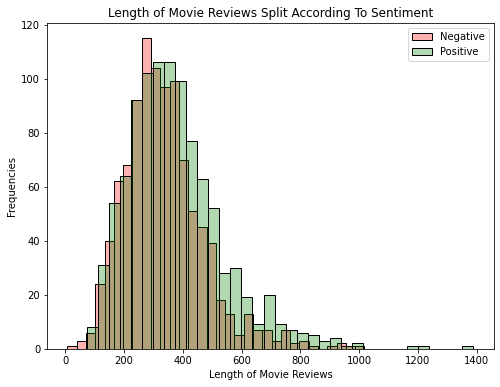

In [10]:
positive = df_new[df_new["target"] == 1]
negative = df_new[df_new["target"]== 0]

plt.figure(figsize=(8, 6))
sns.histplot(negative["text"].map(lambda sentence: len(sentence.split())),
             color="r", alpha=0.3)
sns.histplot(positive["text"].map(lambda sentence: len(sentence.split())),
             color="g", alpha=0.3)
plt.legend(labels=["Negative", "Positive"])
plt.title("Length of Movie Reviews Split According To Sentiment")
plt.xlabel("Length of Movie Reviews")
plt.ylabel("Frequencies")
plt.show()

This is the distribution of the length of movie reviews (word count) split according to sentiment (positive/negative).

From the graphic, we see that positive and negative movie reviews have similar distributions while positive movie reviews(green bars) seem to have a larger average word length. It is in line with common sense as people may write fewer words when they have negative thoughts (red bars).

### Split into training and testing dataset

In [11]:
docs_train, docs_test, y_train, y_test = train_test_split(
    df_new["text"], df_new["target"], test_size=0.25, random_state=123)

In [12]:
# TASK: Build a vectorizer / classifier pipeline that filters out tokens
# that are too rare or too frequent
pipeline = Pipeline([
    ("vect", TfidfVectorizer(min_df=3, max_df=0.95)),
    ("clf", LinearSVC(C=1000, max_iter=10000))  # C is the regularization parameter. The strength of the regularization is inversely proportional to C.
]) # Linear SVC = Linear Support Vector Classification

# TASK: Build a grid search to find out whether unigrams or bigrams are more useful.
# Fit the pipeline on the training set using grid search for the parameters
parameters = {"vect__ngram_range": [(1, 1), (1, 2)]}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1) # n_jobs: number of jobs to run in parallel. -1 means using all processors.
grid_search.fit(docs_train, y_train)

# TASK: print the cross-validated scores for the each parameters set explored by the grid search
print(grid_search.cv_results_)

# TASK: Predict the outcome on the testing set and store it in a variable
# named y_predicted
y_predicted = grid_search.predict(docs_test)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

{'mean_fit_time': array([1.33232284, 3.64614706]), 'std_fit_time': array([1.3421431 , 1.89967805]), 'mean_score_time': array([0.14340539, 0.18190184]), 'std_score_time': array([0.02750801, 0.02974913]), 'param_vect__ngram_range': masked_array(data=[(1, 1), (1, 2)],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'vect__ngram_range': (1, 1)}, {'vect__ngram_range': (1, 2)}], 'split0_test_score': array([0.84333333, 0.85333333]), 'split1_test_score': array([0.83      , 0.83333333]), 'split2_test_score': array([0.85333333, 0.86333333]), 'split3_test_score': array([0.83333333, 0.84333333]), 'split4_test_score': array([0.81333333, 0.81333333]), 'mean_test_score': array([0.83466667, 0.84133333]), 'std_test_score': array([0.01343296, 0.01720465]), 'rank_test_score': array([2, 1], dtype=int32)}
              precision    recall  f1-score   support

         neg       0.86      0.83      0.85       254
         pos       0.83      0.87      0.85    

### Print and plot the confusion matrix

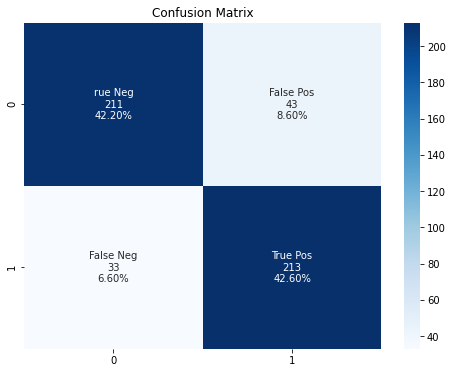

In [13]:
cm = metrics.confusion_matrix(y_test, y_predicted)

group_names = ["rue Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value)
                     for value in cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues") \
    .set(title="Confusion Matrix")
plt.show()

### Machine learning algorithms
+ Based upon the above section pick some parameters for TfidfVectorizer
  + "fit" your TfidfVectorizer using docs_test
  + Compute "Xtrain", a Tf-idf-weighted document-term matrix using the transform function on docs_test 
  + Compute "Xtest", a Tf-idf-weighted document-term matrix using the transform function on docs_train
  + Note, be sure to use the same Tf-idf-weighted class (__"fit" using docs_train__) to transform **both** docs_test and docs_train
+ Examine two classifiers provided by scikit-learn 
  + LinearSVC
  + KNeighborsClassifier
  + Try a number of different parameter settings for each and judge your performance using a confusion matrix (see Problem 1 for an example).
+ Does one classifier, or one set of parameters work better?
  + Why do you think it might be working better?
+ For a particular choice of parameters and classifier, look at 2 examples where the prediction was incorrect.
  + Can you conjecture on why the classifier made a mistake for this prediction?

In [14]:
features = TfidfVectorizer(min_df=3, max_df=0.95, ngram_range=(1, 1))
features.fit(docs_train)
Xtrain = features.transform(docs_train)
Xtest = features.transform(docs_test)

In [15]:
classifier = LinearSVC(C=1000, max_iter=10000, random_state=31415)
classifier.fit(Xtrain, y_train)
y_predicted = classifier.predict(Xtest)
coef = pd.Series(classifier.coef_[0], index=features.get_feature_names())
coef.sort_values(inplace=True)
coef

bad             -2.894262
nothing         -2.183779
unfortunately   -2.105277
attempt         -2.063528
script          -1.964489
                   ...   
matrix           1.697588
performance      1.701914
american         1.829874
fun              1.993086
great            2.188007
Length: 14682, dtype: float64

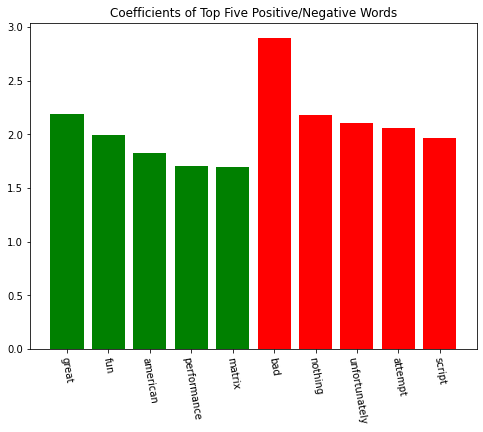

In [16]:
positive = coef[-1:-6:-1]
negative = coef[:5]
to_plot = pd.concat([positive, negative])

plt.figure(figsize=(8, 6))
plt.bar(to_plot.index, to_plot.abs(), color=["g"] * 5 + ["r"] * 5)
plt.xticks(rotation=-80)
plt.title("Coefficients of Top Five Positive/Negative Words")
plt.show()

   Here is the barplot of coefficients of top five positive and negative words. Barplots in red stand for coefficients of top five negative words while green bars represent positive ones. 
   
   By puting absolute values of these negative coefficients, we are easier to compare the magnitude each word has in our prediction model. For example, the word "bad" gives our model pretty clear instructions that the movie review can be negative.

In [17]:
# add weights to these top words and decrease weights for others, then to see what happens to the xy graph
negative_features = coef[:20].index.to_list()
positive_features = coef[-20:].index.to_list()
print(negative_features)
print(positive_features)

['bad', 'nothing', 'unfortunately', 'attempt', 'script', 'supposed', 'stupid', 'worst', 'boring', 'awful', 'look', 'plot', 'wasted', 'could', 'poor', 'ridiculous', 'better', 'material', 'jakob', 'harry']
['ending', 'especially', 'overall', 'people', 'always', 'bulworth', 'together', 'mamet', 'terrific', 'memorable', 'well', 'different', 'marcy', 'trek', 'quite', 'matrix', 'performance', 'american', 'fun', 'great']


### Positive wordcloud

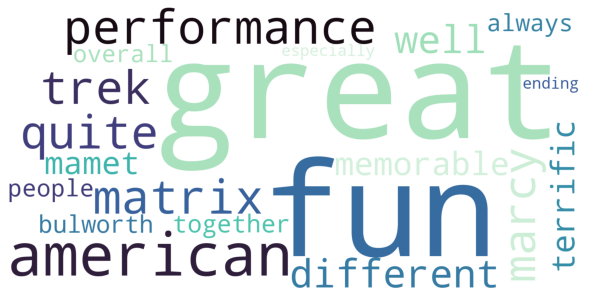

In [18]:
top_20_dict_positive = dict(zip(positive_features, coef[-20:]))
wordcloud = WordCloud(width=1600, height=800, colormap="mako",
                      background_color="white") \
                .generate_from_frequencies(top_20_dict_positive)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Negative wordcloud

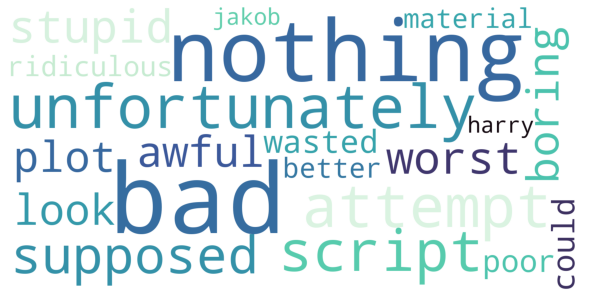

In [19]:
top_20_dict_negative = dict(zip(negative_features, abs(coef[:20])))
wordcloud = WordCloud(width=1600, height=800, colormap="mako",
                      background_color="white") \
                .generate_from_frequencies(top_20_dict_negative)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Split positive and negative points (supervised approach)

In [20]:
negative_features = coef[:200].index.to_list()
positive_features = coef[-200:].index.to_list()

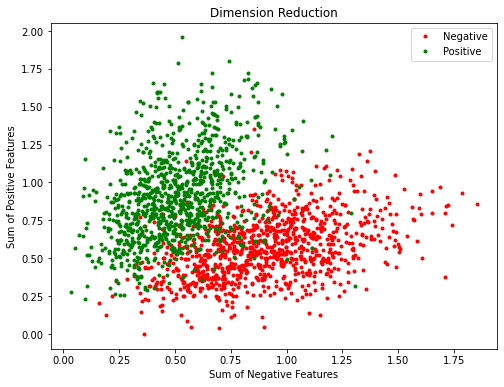

In [21]:
Xtrain_df = pd.DataFrame(Xtrain.toarray(), columns=features.get_feature_names())
Xtest_df = pd.DataFrame(Xtest.toarray(), columns=features.get_feature_names())
X_df = pd.concat([Xtrain_df, Xtest_df])
x1 = np.sum(X_df[negative_features], axis=1)
x2 = np.sum(X_df[positive_features], axis=1)
y = np.concatenate([y_train, y_test])

plt.figure(figsize=(8, 6))
plt.plot(x1[y == 0], x2[y == 0], "r.")
plt.plot(x1[y == 1], x2[y == 1], "g.")
plt.legend(labels=["Negative", "Positive"])
plt.title("Dimension Reduction")
plt.xlabel("Sum of Negative Features")
plt.ylabel("Sum of Positive Features")
plt.show()

# Deep Learning and Transfer to Twitter Data
## Train multi-layer perceptron classifier using the movie review dataset

In [22]:
X_train = Xtrain_df[negative_features + positive_features].values
X_test = Xtest_df[negative_features + positive_features].values

In [23]:
import torch

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

In [24]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 500)
        self.fc2 = nn.Linear(500, 400)
        self.fc3 = nn.Linear(400, 300)
        self.fc4 = nn.Linear(300, 200)
        self.fc5 = nn.Linear(200, 1)
    def forward(self, input_):
        intermediate_vector1 = F.relu(self.fc1(input_))
        intermediate_vector2 = F.relu(self.fc2(intermediate_vector1))
        intermediate_vector3 = F.relu(self.fc3(intermediate_vector2))
        intermediate_vector4 = F.relu(self.fc4(intermediate_vector3))
        prediction_vector = torch.sigmoid(self.fc5(intermediate_vector4))
        return prediction_vector

In [25]:
mlp = MLPClassifier() 

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0005)

In [26]:
num_epochs = 500
y_train = y_train.values.reshape(-1, 1)

for i in range(1, num_epochs + 1):
    # the training routine is these 5 steps:
    # step 1. zero the gradients
    optimizer.zero_grad()
    # step 2. compute the output
    y_pred = mlp(X_train.float())
    # step 3. compute the loss
    loss = loss_func(y_pred, torch.tensor(y_train, dtype=torch.float))
    # step 4. use loss to produce gradients
    loss.backward()
    # step 5. use optimizer to take gradient step
    optimizer.step()
    if i % 25 == 0:
        print("Epoch {} completed, loss: {}".format(i, loss.item()))

Epoch 25 completed, loss: 0.6888987421989441
Epoch 50 completed, loss: 0.6384390592575073
Epoch 75 completed, loss: 0.5594266653060913
Epoch 100 completed, loss: 0.5051760077476501
Epoch 125 completed, loss: 0.5046692490577698
Epoch 150 completed, loss: 0.5046447515487671
Epoch 175 completed, loss: 0.5046386122703552
Epoch 200 completed, loss: 0.5046355128288269
Epoch 225 completed, loss: 0.5046321153640747
Epoch 250 completed, loss: 0.5043841004371643
Epoch 275 completed, loss: 0.5043816566467285
Epoch 300 completed, loss: 0.5043799877166748
Epoch 325 completed, loss: 0.504379391670227
Epoch 350 completed, loss: 0.5043789744377136
Epoch 375 completed, loss: 0.5043786764144897
Epoch 400 completed, loss: 0.5043784379959106
Epoch 425 completed, loss: 0.5043783187866211
Epoch 450 completed, loss: 0.5043781995773315
Epoch 475 completed, loss: 0.504378080368042
Epoch 500 completed, loss: 0.504378080368042


In [27]:
y_predicted = mlp(X_test.float())
y_predicted = (torch.round(y_predicted)).detach().numpy().astype(int)

cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

[[206  48]
 [ 53 193]]


## Transfer learning
Now we put all the pieces together:
1. We get data from our MongoDB data using a interesting query
2. We leverage all of our pretrained algorithms
3. We make predictions on a new dataset using (simple) transfer learning!

In [28]:
import json
import pymongo

q = "Toyota"

# The connection string for a remote hosted mongodb running on MongoDB atlas
client = pymongo.MongoClient("Paste MongoDB connection here")
# Get a reference to a particular database
db = client["twitter"]
# Reference a particular collection in the database
coll = db["statuses_" + q]

### Do a search!
See https://docs.mongodb.org/getting-started/python/query/ and https://docs.mongodb.org/manual/tutorial/query-documents/ for details

In [29]:
cursor = coll.find({"$and": [{"metadata.iso_language_code": {"$eq": "en"}},
                             {"$or": [{"retweeted": "true"},
                                      {"text": {"$regex": ".*car.*",
                                                "$options": "i"}}
                                     ]}
                            ]})
X_tweet = [tweet["text"] for tweet in cursor]
X_tweet[:10]

['@stugates @duncanjohnson72 @DaveKeating Nissan are building a massive car battery factory ... Toyota is a threat ..… https://t.co/Uc0aflF4PK',
 'Car News of Today 🚗\nMr VA Auto\n.\nBMW recalls Toyota Supra for potential loss of power brake assistance\n.\nMr VA Auto… https://t.co/Q1f1Yg4Ja5',
 '@smilingnodding @roun_sa_ville i went to a used car dealer out in van nuys w/my sister last saturday and the dude w… https://t.co/QkcYLZ7vMI',
 'RT @seh_clements: Cause Ozo and Amadi are in Zanzibar, I wonder who is guarding our new house and our new 2019 Brand New Toyota Prado car a…',
 "Toyota's Road-Going Hypercar Might Have Been Axed | Carscoops #carscoops https://t.co/WFqtGaAQ7e",
 'ICYMI: #STL Area #Toyota Dealers to sponsor @WWTRaceway @NASCAR_Trucks 200 on August 20: https://t.co/lDshMCznsV… https://t.co/NN9WwY28yh',
 '@Toyota fix my car!!! I’ve had it 7 months how is it not working????? I ain’t paying my bill this month i can’t even drive it bye!!!!!!',
 'RT @literallysofie: when you a

### Use our pretrained preprocessing chain

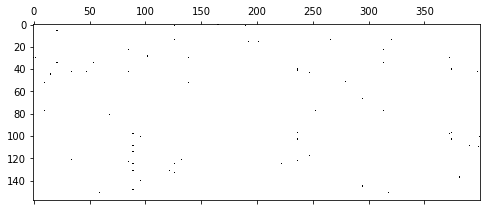

In [30]:
X_tweet_features = features.transform(X_tweet)
X_tweet_df = pd.DataFrame(X_tweet_features.toarray(),
                          columns=features.get_feature_names())
X_tweet_reduced = X_tweet_df[negative_features + positive_features].values

plt.figure(figsize=(8, 6))
plt.spy(X_tweet_reduced)
plt.show()

In [31]:
X_tweet_reduced = torch.from_numpy(X_tweet_reduced)
y_tweet_predicted = mlp(X_tweet_reduced.float())

In [32]:
for i in range(10):
    print(X_tweet[i])
    print((torch.round(y_tweet_predicted[i])).detach().numpy().astype(int))
    print()

@stugates @duncanjohnson72 @DaveKeating Nissan are building a massive car battery factory ... Toyota is a threat ..… https://t.co/Uc0aflF4PK
[0]

Car News of Today 🚗
Mr VA Auto
.
BMW recalls Toyota Supra for potential loss of power brake assistance
.
Mr VA Auto… https://t.co/Q1f1Yg4Ja5
[0]

@smilingnodding @roun_sa_ville i went to a used car dealer out in van nuys w/my sister last saturday and the dude w… https://t.co/QkcYLZ7vMI
[0]

RT @seh_clements: Cause Ozo and Amadi are in Zanzibar, I wonder who is guarding our new house and our new 2019 Brand New Toyota Prado car a…
[0]

Toyota's Road-Going Hypercar Might Have Been Axed | Carscoops #carscoops https://t.co/WFqtGaAQ7e
[0]

ICYMI: #STL Area #Toyota Dealers to sponsor @WWTRaceway @NASCAR_Trucks 200 on August 20: https://t.co/lDshMCznsV… https://t.co/NN9WwY28yh
[0]

@Toyota fix my car!!! I’ve had it 7 months how is it not working????? I ain’t paying my bill this month i can’t even drive it bye!!!!!!
[0]

RT @literallysofie: when you a